## ## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [sub-Part III - Timestamp](#timestamp)


<a id='intro'></a>
### Introduction

An A/B test of performig different landing pages on e-commerce website.  The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv'); df.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df[df['converted'] == 1].user_id.nunique() / df['user_id'].nunique()

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df[(df['group'] == 'treatment') & (df['landing_page'] != 'new_page')].shape[0] +\
df[(df['group'] != 'treatment') & (df['landing_page'] == 'new_page')].shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()
print('No one of rows has missing value')

No one of rows has missing value


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. 

In [8]:
#list of rows to drop under the term that "treatment" does not match with  "new_page"
drop_list_1 = df[(df['group'] == 'treatment') & (df['landing_page'] != 'new_page')].index.tolist()
#list of rows to drop under the term that "new_page" does not match with  "treatment"
drop_list_2 = df[(df['group'] != 'treatment') & (df['landing_page'] == 'new_page')].index.tolist()

In [9]:
#drop unsuitable rows and store the result in new data frame df2
df2 = df.drop(drop_list_1 + drop_list_2)

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page'))== False].shape[0]

0

a. How many unique **user_id**s are in **df2**?

In [11]:
df2.nunique()


user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

Since we have timestamps for **290585** visits and only **290584** unique ids, we assume that one id is repeated in two sessions

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
#get the value of duplicated id
rep_id = df2[df2['user_id'].duplicated()].reset_index(drop = True).iloc[0,0]; rep_id

773192

c. What is the row information for the repeat **user_id**? 

In [13]:
#subset of data frame with duplicated usere_id
df2[df2['user_id'] == rep_id]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


- Rows with the duplicated user_id **773192** has indexes **1899** and **2893** 
- These rows has different timestamps, same group **treatment** and same landing_page **new_page**

d. Remove **one** of the rows with a duplicate **user_id**, but keep dataframe as **df2**.

In [14]:
# drop the row with index 1899
df2 = df2.drop(1899); df2.head(1)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0


a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2[df2['converted'] == 1].shape[0] / df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
actual_p_old = df2[(df2['group'] == 'control') & (df2['converted'] == 1)].shape[0]  / df2[df2['group'] == 'control'].shape[0]
actual_p_old

0.1203863045004612

In [17]:
df2[(df2['group'] == 'control') & (df2['landing_page'] == 'old_page')].shape[0] 

145274

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
actual_p_new = df2[(df2['group'] == 'treatment') & (df2['converted'] == 1)].shape[0]  / df2[df2['group'] == 'treatment'].shape[0]
actual_p_new

0.11880806551510564

In [19]:
df2[(df2['group'] == 'treatment') & (df2['landing_page'] == 'new_page')].shape[0] 

145310

d. What is the probability that an individual received the new page?

In [20]:
df2[df2['landing_page'] == 'new_page'].shape[0] / df2.shape[0]

0.5000619442226688

Actual diffenrence between conversions

In [21]:
act_diff = actual_p_new - actual_p_old; act_diff

-0.0015782389853555567

Consider the results from above we **don't have statistically significant evidence** that new page leads to more conversions.
As we see, the probability that an individual received the new page in our test is 0.5. This confirmed by followed absolute numbers:
- the number of individuals in the treatment group received new page is **145310**
- the number of individuals in the control group received old page is **145274**

These digits allowed us to say that we comparing equal numbers of tests old page and new page. And the test is fair enough.

Based on the probability of converting we got above, we see that number for the new page is **0.1188** and it is less than the probability for old page **0.1204**. 

Technically speaking these numbers almost even, so instead of the statement that old page converts more, the preferred statement is 
> "we don't have statistically significant evidence that new page converting more, then old page"

<a id='ab_test'></a>
### Part II - A/B Test


In terms of words:
> NULL is : The conversion of new page not more than conversion of old page

> ALT is: The convesion of new page bigger than convirsion of old page


In terms of notation:


**<center>NULL :           $P_{new} - P_{old} <= 0$</center>**
    
**<center>ALT :               $P_{new} - P_{old} > 0$</center>**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


a. What is the **conversion rate** for $p_{new}$ under the null? 

In [22]:
p_new = df2[df2['converted'] == 1].shape[0] / df2.shape[0]
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [23]:
p_old = df2[df2['converted'] == 1].shape[0] / df2.shape[0]
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [24]:
n_new = df2[df2['group'] == 'treatment'].shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [25]:
n_old = df2[df2['group'] == 'control'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [26]:
new_page_converted = np.random.binomial(1, p_new, n_new)

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [27]:
old_page_converted = np.random.binomial(1, p_old, n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [28]:
# p_new value from array simulated above
p_new_2 = (new_page_converted == 1).sum() / len(new_page_converted); p_new_2

0.11991604156630652

In [29]:
# p_old value from array simulated above
p_old_2 = (old_page_converted == 1).sum() / len(old_page_converted); p_old_2

0.12017291463028484

In [30]:
#difference between new p_new and p_old
p_new_2 - p_old_2

-0.00025687306397832732

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [31]:
p_diffs = []
for _ in range (10000):
    new_page_converted = np.random.binomial(1, p_new, n_new)
    p_new_2 = (new_page_converted == 1).sum() / len(new_page_converted)
    old_page_converted = np.random.binomial(1, p_old, n_old)
    p_old_2 = (old_page_converted == 1).sum() / len(old_page_converted)
    p_diffs.append(p_new_2 - p_old_2)


In [32]:
#an array of simulated differences between probabilities of conversion with the new page and the old page
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  

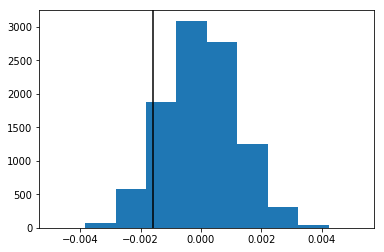

In [33]:
plt.hist(p_diffs)
plt.axvline(act_diff, color = 'black'); # point to the the actual difference between conversion rates, observed in data set

This histogram looks like what we expected to get as we made the big enough sampling to perform our testing. Under the central limit theory, the big enough sampling distribution should be the normal distribution with the bell-shaped graph. Anyway - let's check it twice with another method...

In [34]:
#the standart diviation of values in simulated array
p_diffs_std = np.std(p_diffs); p_diffs_std

0.0012071194538169593

In [35]:
#the simulated array with std-value we got above and under the NULL statement
null_valls = np.random.normal(0, p_diffs_std, 10000)

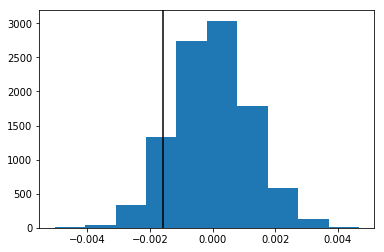

In [36]:
plt.hist(null_valls)
plt.axvline(act_diff, color = 'black');

Both graph looks very similar

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [37]:
#as we assume in point 2 - for the actual observed data in ab_data.csv - the p_new equal to p_old, so the observed p_diff is zero
# lets compare our simulated p_diffs with zero
(p_diffs > act_diff).sum() / len(p_diffs)

0.90210000000000001

Lets build the confident interval for our sampling distribution

In [38]:
np.percentile(p_diffs, 2.5), np.percentile(p_diffs, 97.5)

(-0.0023626990324980869, 0.0023791463260130455)

**Conclusion**
The number 0.90 we just got in part j** is a **P-value** under the NULL statement. 

Since the  P-value under the NULL is greater than Type I error rate 5% (90% > 5%) - we fail to reject the NULL statement

In the semi-terms of words, 0.90 is the probability that our observed data comes out from NUll hypotheses. While our P-value higher than Type I Error rate, this probability concider high enough to reject the idea that NULL hypothesis is false.

By another way to make a decision - our observed difference of conversions lies inside our confident interval of sampling distribution under the NULL hypotheses.<br> This statement may be expressed this way: -0.00237 < act_diff == -0.0015 < 0.0024. It is mean, that NULL Hypothesis more likely to fit with real observed data, than ALT hypotheses. 

In the full-terms of words - the results of our experiment do not show statistically significant evidence that the conversion of new landing page much better than the conversion of the old landing page.<br><br><br>

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [39]:
import statsmodels.api as sm
# old page convirsion rate obtained from initial data frame
convert_old = df2[(df2['group'] == 'control') & (df2['converted'] == 1)].shape[0]  / \
df2[df2['group'] == 'control'].shape[0]

# new page convirsion rate obtained from initial data frame
convert_new = df2[(df2['group'] == 'treatment') & (df2['converted'] == 1)].shape[0]  / \
df2[df2['group'] == 'treatment'].shape[0]

# number of individuals received old page
n_old = df2[df2['landing_page'] == 'old_page'].shape[0]

# number of individuals received new page
n_new = df2[df2['landing_page'] == 'new_page'].shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute test statistic and p-value. 

In [67]:
#we choose alternative as "smaller" since our ALT is the 'convert_old' smaller then 'convert_new'
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative = 'smaller')
print('\n','Z-score = ' ,z_score,'\n', 'P-value = ', p_value)


 Z-score =  0.00328757967535 
 P-value =  0.50131155217


**After performing z-test with the built-in function we got**
> P-value = 0.50 <br> This value much bigger then our Type I error rate and under this value we do not have statistically significant evidence to reject in this test our NULL statement, that states no difference between conversions of the new page and the old page

> Z-score = 0.0033 <br> As soon as our z-score sooo little we can say that results of out test lies inside the confident interval, technically they lie very close to the mean of the distribution of differences produced during the test. Since our test aimed to get a multi-comparison between conversions on the new page and on the old page, we can say that, based on z-score, this multi-comparison do not produce statistically significant differences between these conversions.

> This z-test allow to make the same conclusion as we made in previous test - fail to reject the NULL theory

<a id='regression'></a>
### Part III - A regression approach

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**We need to perform the Logistic regression, since we have only two logic outputs: "yes" or "no", "1" or "0"**

b. The goal is to use **statsmodels** to fit the regression model specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [41]:
# create a column with an intercept
df2['intercept'] = 1
# create 'ab_page' column with dummy  variables '1' for treatment, '0' for control
df2['ab_page'] = df2['group'].apply(lambda x: 1 if x == 'treatment' else 0)
df2.head(3)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1


c. Use **statsmodels** to instantiate regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [42]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = log_mod.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of model below, and use it as necessary to answer the following questions.

In [43]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 28 Feb 2019   Pseudo R-squ.:               8.077e-06
Time:                        19:35:38   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

**In this logistic regression model** we stated the following hypotheses:<br><br>

> **NULL :** The type of landing page does not have statistically significant impact  on the fact whether visitor will be converted or not <br><br>
> **ALT :** The type of landing page does not have statistically significant impact  on the fact whether visitor will be converted or not <br><br>

The P-Value we got from the model has a value of **0.19**. It differs from P-value we got from the previous analysis because different models have different hypotheses<br><br>

<a id='timestamp'></a>
### Timestamp
<br>As soon as we didn't find a significant proof that different landing pages effect to the conversion, let's take a look at another factor - ***timestamp**. We want to build a logistic regression to identify whether or not the time interval influences the conversion rate. <br><br>
**So out new NULl hypothesis is:** 
> "The daytime when visitor received our landing page has no impact on conversion rate. 

<br>**New ALT hypothesis is:**
> Daytime has a statistically significant impact on conversion rate

<br> First of all, let's create some intervals out of timestamp data we have.

In [45]:
#get a data type of timestamp column
df2.timestamp.dtype

dtype('O')

So the data type os "Object', that consider as "string" in pandas data frame and allow us to operate with data as with string.<br><br> <br> 
The idea of intervals is to cut 24 hours in four parts and build four following intervals:
> **Night** - from 00 hours to 05 hours<br> 
> **Morning** - from 6 hours to 11 hours<br> 
> **Afternoon** - from 12 hours to 17 hours<br> 
> **Evening** - from 18 hours to 23 hour<br> 

<br> So, we going to cut out from timestamp all data about the date, minutes and seconds - just to left info about a particular hour during which our visitor received the landing page. Then we going compare visit hours with our intervals mentioned above and assign the specific group to each visitor.<br> <br>

In [46]:
# Create new column as a copy od timestamp column and left in it just info about hour session
df2['visit_hour'] = df2['timestamp'].apply(lambda x: x[10:-13]); df2.head(3)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,visit_hour
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,22
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,08
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,16


In [47]:
#convert data type in 'visit_hour' column from 'str' to 'int
df2['visit_hour'] = df2['visit_hour'].astype(int); df2['visit_hour'].dtype

dtype('int64')

In [48]:
%%time
#create new column 'datime' and assign to it specific groups depened on the hour in column 'visit_hour'
df2['daytime'] = \
['Night' if 0<=x<=5 else ('Morning' if 6<=x<=11 else('Afternoon' if 12<=x<=17 else 'Evening')) for x in df2['visit_hour']]

CPU times: user 173 ms, sys: 5 µs, total: 173 ms
Wall time: 173 ms


In [49]:
#create dummy variables for 'daytime' column
dummies = pd.get_dummies(df2['daytime']); dummies.head()

,Afternoon,Evening,Morning,Night
0,0,1,0,0
1,0,0,1,0
2,1,0,0,0
3,0,1,0,0
4,0,0,0,1


In [50]:
#join two dataframes
df2 = df2.join(dummies); df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,visit_hour,daytime,Afternoon,Evening,Morning,Night
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,22,Evening,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,8,Morning,0,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,16,Afternoon,1,0,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,18,Evening,0,1,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,Night,0,0,0,1


Let's take a look on logistic regression  - how conversion depends on daytime groups <br>

In [51]:
#instantiate the model
lg_mod = sm.Logit(df2['converted'], df2[['intercept','Morning', 'Afternoon', 'Evening']])
# fit it
result = lg_mod.fit()
#get a summary
result.summary()

Optimization terminated successfully.
         Current function value: 0.366103
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 28 Feb 2019   Pseudo R-squ.:               4.990e-05
Time:                        19:35:39   Log-Likelihood:            -1.0638e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                   0.01398
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0286      0.012   -175.189      0.000      -2.051      -2.006
Morning        0.0407      0.016      2.505      0.012       0.009       0.073
Afternoon      0.0413      0.016      2.544      0.011       0.009       0.073
Evening        0.0467      0.016      2.879      0.004       0.015       0.079
==============================================================================
"""

In [52]:
np.exp(0.0407), np.exp(0.0413), np.exp(0.0467)

(1.0415395967924728, 1.0421647080651766, 1.047807619637706)

**Conclusion** - Analysing the results of logistic regression we can say, that we have statistically significant evidence to reject our NULL hypothesis that daytime has no effect on conversion rate. All P-values are lower than Type I Error rate. So, It does!<br>
More than that - we can say, that visited the website in the time between 6 am and 11 pm, the person has more odds to be converted, than in the night. The most effective interval is  "Evening" - we may expect a higher conversion rate on visitors between 6 pm and 11 pm. So  if we looking for the better daytime to spend more money on advertising - the evening is the best time.<br><br>
**In other words** - at the evening the visitor is 1.048 times likely to be converted, then at the night time.<br> 